In [1]:
from utils.notebook_2_utils import * 
import utils.notebook_2_utils as utils

training_df = pd.read_csv("data/training.csv")
lookup_df = pd.read_csv("data/IdLookupTable.csv")
training_df.fillna(method = 'ffill',inplace = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
train_X, train_Y, val_X, val_Y = create_train_test_sets_nchw(training_df, normalize=True)

## Very Simple CNN Model
* Input shape:  64, 1, 96, 96 (nchw)
* Output shape: 64, 30 (nc)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
import torch.nn.functional as F

### Model Definition

In [4]:
class CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_dim: int, output_dim: int):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(hidden_dim * 24 * 24, hidden_dim) #this is multiplied by 7*7 because the image is 28*28 and we have 2 conv layers with stride 1 and padding 1
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Control Panel

In [5]:
cnn = CNN(input_shape=1, hidden_dim=64, output_dim=30)

EPOCHS = 40
LEARNING_RATE = .02
BATCH_SIZE = 32


loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=LEARNING_RATE)





### DataLoaders

In [6]:
torch.manual_seed(42)
from torch.utils.data import TensorDataset, DataLoader


# Put data to target device
train_X, train_Y = train_X.to(device), train_Y.to(device)
val_X, val_Y = val_X.to(device), val_Y.to(device)
cnn = cnn.to(device)

train_dataset = TensorDataset(train_X, train_Y)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(val_X, val_Y)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
for X_batch, y_batch in train_dataloader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([32, 1, 96, 96]) torch.Size([32, 30])


In [8]:
for X_batch, y_batch in test_dataloader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([32, 1, 96, 96]) torch.Size([32, 30])


In [9]:
for idx,batch in enumerate(train_dataloader):
    print("batch input: ", batch[0].size())
    print("batch idx: ",  idx)
    print("batch label: " , batch[1].shape)
    break

print("---------- test dataloader -------")
for idx, (data,target) in enumerate(test_dataloader):
    print(idx, data.shape)
    print(idx, target.shape)
    break

batch input:  torch.Size([32, 1, 96, 96])
batch idx:  0
batch label:  torch.Size([32, 30])
---------- test dataloader -------
0 torch.Size([32, 1, 96, 96])
0 torch.Size([32, 30])


In [10]:
preds = cnn(X_batch)

In [11]:
y_batch.shape

torch.Size([32, 30])

In [12]:
loss_fn(preds, y_batch)

tensor(0.2671, device='cuda:0', grad_fn=<MseLossBackward0>)

# Gradient Accumilation

## The same training loop but with gradient accumilation added
## __NOTE__: Only run one option
Why: some GPU's may run out of memory, but changing batch size will require varying learning rate and confuse things

In [13]:
# X_blob_train, y_blob_train = train_X, train_Y
# X_blob_test, y_blob_test = val_X, val_Y

for epoch in range(EPOCHS):
    ### Training mode 
    cnn.train()

    
    # Set the number of batches to accumulate gradients over
    accumulation_steps = 4

    # Initialize a counter to keep track of the number of accumulated batches
    accumulation_counter = 0

    # Create an empty tensor to accumulate gradients over the accumulation steps
    grad_acc = {k: torch.zeros_like(v) for k, v in cnn.named_parameters()}

    for X_batch, y_batch in train_dataloader:

        # 1. Forward pass (model outputs raw logits)
        y_logits = cnn(X_batch)

        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_batch)

        # 3. Loss backwards
        loss.backward()

        # 4. Accumulate gradients over the accumulation steps
        accumulation_counter += 1
        if accumulation_counter == accumulation_steps:
            for param_name, param in cnn.named_parameters():
                grad_acc[param_name] += param.grad / accumulation_steps
            accumulation_counter = 0

        # 5. Optimizer step (only update weights after accumulating gradients over accumulation_steps)
        if accumulation_counter == 0:
            for param_name, param in cnn.named_parameters():
                param.grad = grad_acc[param_name]
            optimizer.step()
            optimizer.zero_grad()

    # Check if there are any remaining accumulated gradients to update
    if accumulation_counter != 0:
        for param_name, param in cnn.named_parameters():
            param.grad = grad_acc[param_name]
        optimizer.step()
        optimizer.zero_grad()

    
    
    cnn.eval()
    with torch.inference_mode():
        for X_batch, y_batch in test_dataloader:
            test_logits = cnn(X_batch)
            test_loss = loss_fn(test_logits, y_batch)
            
            
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.02694 | Test Loss: 0.00597
Epoch: 10 | Loss: 0.00221 | Test Loss: 0.00074
Epoch: 20 | Loss: 0.00115 | Test Loss: 0.00066
Epoch: 30 | Loss: 0.00463 | Test Loss: 0.00045


## Predictions


In [14]:
preds = cnn(val_X.to(device))

In [15]:
preds.shape

torch.Size([1409, 30])

In [16]:
val_Y.shape

torch.Size([1409, 30])

In [17]:
loss_fn(preds, val_Y)

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)

In [18]:
val_X.shape, preds.shape, val_Y.shape

(torch.Size([1409, 1, 96, 96]), torch.Size([1409, 30]), torch.Size([1409, 30]))

In [19]:
preds[0][1]

tensor(0.3902, device='cuda:0', grad_fn=<SelectBackward0>)

In [20]:
val_X[1].shape, val_X[1][0].shape

(torch.Size([1, 96, 96]), torch.Size([96, 96]))

In [21]:
def show_pred(X, preds, actual, index, point):
    plt.imshow(X[index][0],cmap='gray')

    plt.scatter(96* preds[index][point],96* preds[index][point + 1] ,c='r', marker='s', s=60, alpha=.5)
    plt.scatter(96*actual[index][point],96* actual[index][point+1],c='g', marker='s', s=60, alpha=.5)

    plt.legend(['predicted','actual'])
    


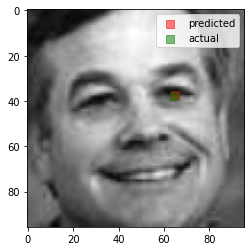

In [22]:
show_pred(val_X.to("cpu"), preds.to("cpu").detach().numpy(), val_Y.to("cpu").detach().numpy(), 0, 0)

In [23]:
preds[0][0], preds[0][1]

(tensor(0.6769, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(0.3902, device='cuda:0', grad_fn=<SelectBackward0>))

In [24]:
val_Y[0][0], val_Y[0][1]

(tensor(0.6736, device='cuda:0'), tensor(0.3915, device='cuda:0'))

In [25]:
val_X[0][0]

tensor([[0.1843, 0.1529, 0.1255,  ..., 0.2902, 0.2980, 0.3137],
        [0.1725, 0.1529, 0.1333,  ..., 0.2863, 0.2941, 0.3059],
        [0.1686, 0.1608, 0.1451,  ..., 0.2863, 0.2941, 0.2980],
        ...,
        [0.2902, 0.2902, 0.2902,  ..., 0.2314, 0.2353, 0.2392],
        [0.2980, 0.2902, 0.2863,  ..., 0.2353, 0.2392, 0.2471],
        [0.3059, 0.2941, 0.2824,  ..., 0.2431, 0.2431, 0.2471]],
       device='cuda:0')